In [2]:
import json
import math
import pandas as pd
import numpy as np
import plotly.express as px

In [ ]:
z_data = np.empty((5, 5))

for datapoint in tuning:
    
    print(f"{math.log10(float(datapoint['learning_rate']))} {math.log10(float(datapoint['decay']))}")
    
    z_data[int(-1 * math.log10(float(datapoint['learning_rate']))) - 1, int(-1 * math.log10(float(datapoint['decay']))) - 1] = float(datapoint['train_accuracy'])
    
    
z_data = pd.DataFrame(z_data)

In [32]:
mlparams = pd.read_csv('../hyperparameters-mlp.csv')

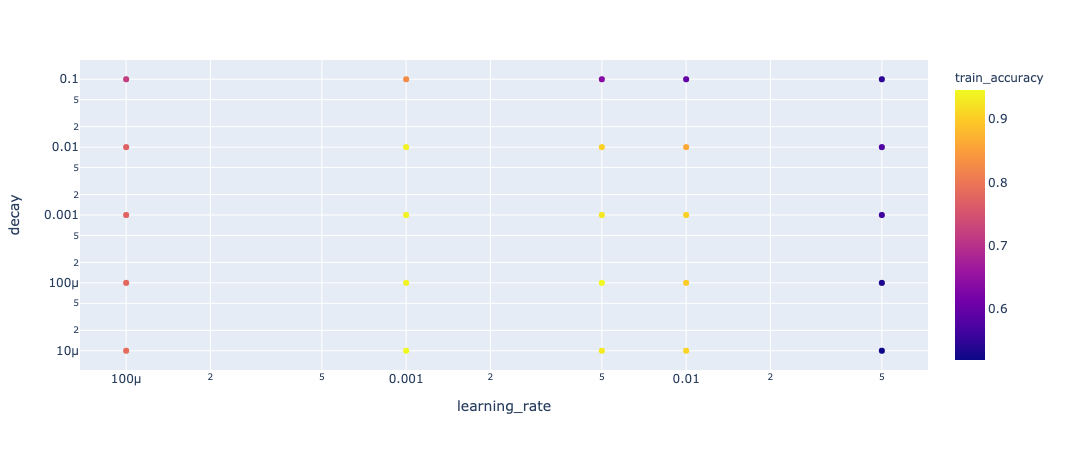

In [36]:
fig = px.scatter(mlparams, x='learning_rate', y='decay',
                    log_x=True, log_y=True,
                    color='train_accuracy')
fig.show()

In [3]:
params1 = pd.read_csv('../hyperparameters.csv')
params2 = pd.read_csv('../hyperparameters-run-1.csv')

params = pd.concat([params1, params2])

In [4]:
params.shape

(175, 5)

In [8]:
fig = px.scatter_3d(params, x='learning_rate', y='decay', z='gamma',
                    log_x=True, log_y=True,
                    color='test_accuracy')
fig.show()

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
params.iloc[156]

learning_rate     0.01000
decay             0.00010
gamma             0.25000
train_accuracy    0.96036
test_accuracy     0.94000
Name: 106, dtype: float64

<AxesSubplot:xlabel='decay', ylabel='test_accuracy'>

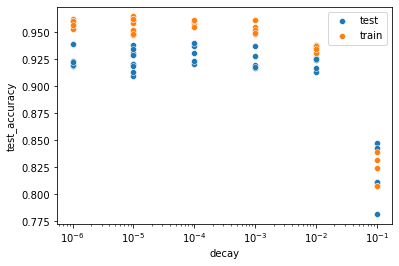

In [19]:
fig, ax = plt.subplots()
ax.set(xscale="log")

sns.scatterplot(data=params[params['learning_rate'] == .01], x='decay', y='test_accuracy', label='test')
sns.scatterplot(data=params[params['learning_rate'] == .01], x='decay', y='train_accuracy', label='train')

<AxesSubplot:xlabel='learning_rate', ylabel='test_accuracy'>

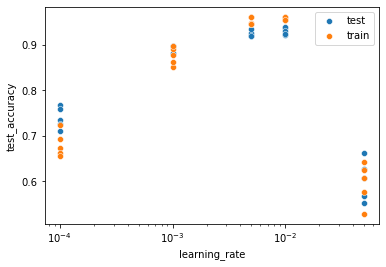

In [20]:
fig, ax = plt.subplots()
ax.set(xscale="log")

sns.scatterplot(data=params[params['decay'] == 1e-4], x='learning_rate', y='test_accuracy', label='test')
sns.scatterplot(data=params[params['decay'] == 1e-4], x='learning_rate', y='train_accuracy', label='train')

<AxesSubplot:xlabel='gamma', ylabel='test_accuracy'>

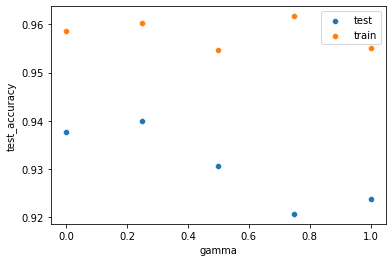

In [22]:
sns.scatterplot(data=params[(params['decay'] == 1e-4) & (params['learning_rate'] == .01)], x='gamma', y='test_accuracy', label='test')
sns.scatterplot(data=params[(params['decay'] == 1e-4) & (params['learning_rate'] == .01)], x='gamma', y='train_accuracy', label='train')

<AxesSubplot:xlabel='gamma', ylabel='test_accuracy'>

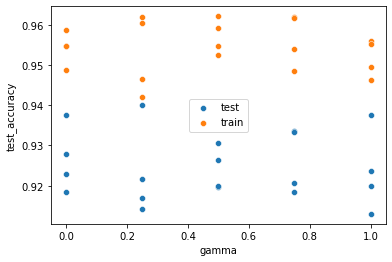

In [29]:
sns.scatterplot(data=params[(params['decay'].isin([1e-4, 1e-3])) & (params['learning_rate'].isin([1e-2, 5e-3]))], x='gamma', y='test_accuracy', label='test')
sns.scatterplot(data=params[(params['decay'].isin([1e-4, 1e-3])) & (params['learning_rate'].isin([1e-2, 5e-3]))], x='gamma', y='train_accuracy', label='train')

In [ ]:
fig, ax = plt.subplots()
ax.set(xscale="log", yscale="log")

sns.scatterplot(data=params, x='learning_rate', y='train_accuracy', ax=ax)

In [ ]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [8.3, 5.1]

In [ ]:
from utils import load_dataset
from metrics import TrainingMetrics

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
class Net(nn.Module):
    def __init__(self, nb_hidden):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(2, 24, kernel_size=3)
        self.conv2 = nn.Conv2d(24, 49, kernel_size=3)
        
        # fully connected layers
        self.fc1 = nn.Linear(196, 128)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20, 10)
        self.classifier = nn.Linear(10, 1)
        
        # Regularizers
        self.drop = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2,2)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        
        x = self.relu(self.fc1(x.flatten(start_dim=1)))
        x = self.drop(x)
        
        x = self.relu(self.fc2(x))
        x = self.drop(x)
        
        x = self.relu(self.fc3(x.flatten(start_dim=1)))
        
        x = self.sigmoid(self.classifier(x))
        
        return x.squeeze(), None

In [ ]:
train_loader, test_loader = load_dataset()

In [ ]:
model = Net(200)

In [ ]:
def accuracy(model, load):
    
    accuracy = 0.
    counter = 0
    
    model.eval()
    
    with torch.no_grad():
            for (input, target, _) in load:
                output, _ = model(input)
                
                accuracy += (output >= 0.5) == target
                counter += target.size(0)
                
    return (accuracy.sum() / counter).float().item()

In [ ]:
criterion = nn.BCELoss()
eta = 1e-2
epochs = 25
decay = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=decay)

metrics = TrainingMetrics()

for epoch in range(epochs):
    
    acc_loss = 0.
    
    model.train()
    
    for input, target, classes in train_loader:
        
        output, aux = model(input)
        loss = criterion(output, target.float())
        
        acc_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    metrics.add_entry(epoch, acc_loss, accuracy(model, train_loader))
    print(metrics)

In [ ]:
print(f"{4.555:06.3f}")

In [ ]:
import pandas as pd
import seaborn as sns

training_stats = pd.DataFrame.from_dict(stats, orient='index')
training_stats['epoch'] = training_stats.index

In [ ]:
ax_loss = sns.lineplot(data=training_stats, x="epoch", y="loss", label='loss')

ax_acc = ax_loss.twinx()

sns.lineplot(data=training_stats, x="epoch", y="accuracy", label='accuracy', ax=ax_acc, color='r')

plt.show()

In [10]:
import pandas as pd

In [11]:
tm = pd.read_csv('../testing_metrics.csv')

In [12]:
tm.accuracy.mean()

0.9062000000000001

In [20]:
import sys, os

sys.path.append(os.path.abspath('../src'))

import torch
from models.siamese_convnet import SiameseConvNet

In [24]:
model = SiameseConvNet()

x = torch.randn(1, 2, 14, 14)

y = model(x)

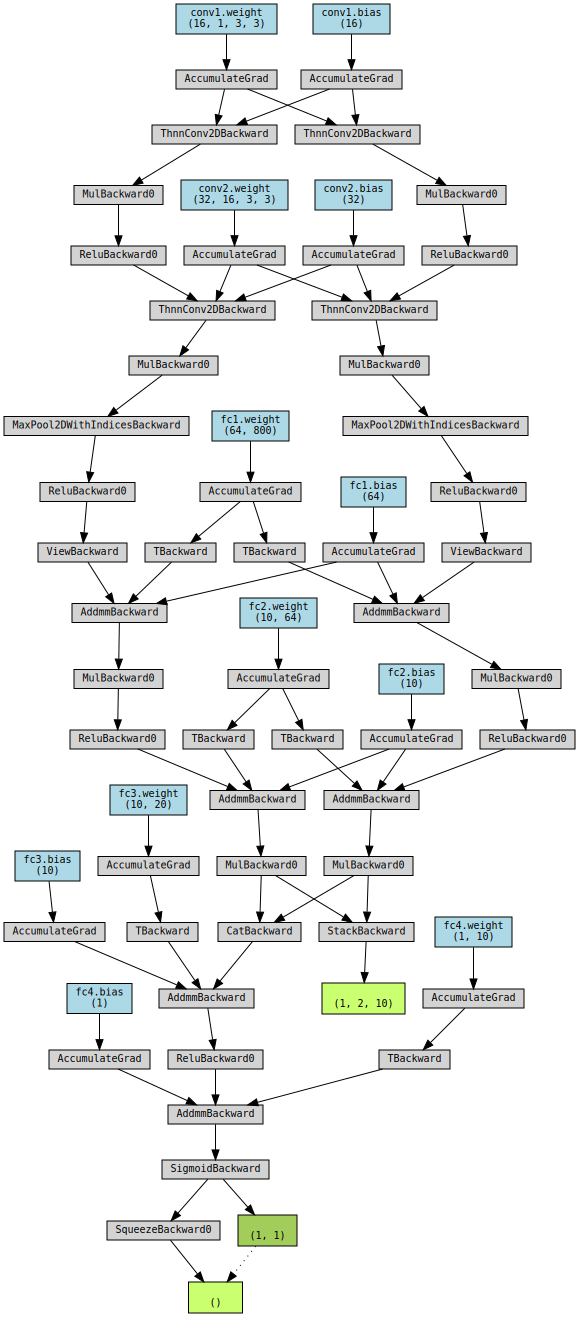

In [36]:
from torchviz import make_dot

make_dot(y, params=dict(model.named_parameters()))

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7fb48e892790>)

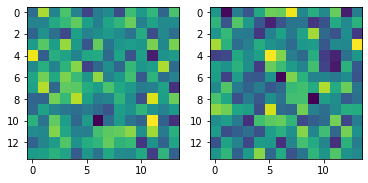

In [30]:
import matplotlib.pyplot as plt

plt.subplot(121), plt.imshow(x[0, 0, :, :])
plt.subplot(122), plt.imshow(x[0, 1, :, :])